In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [3]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) 
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

        
def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0  
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


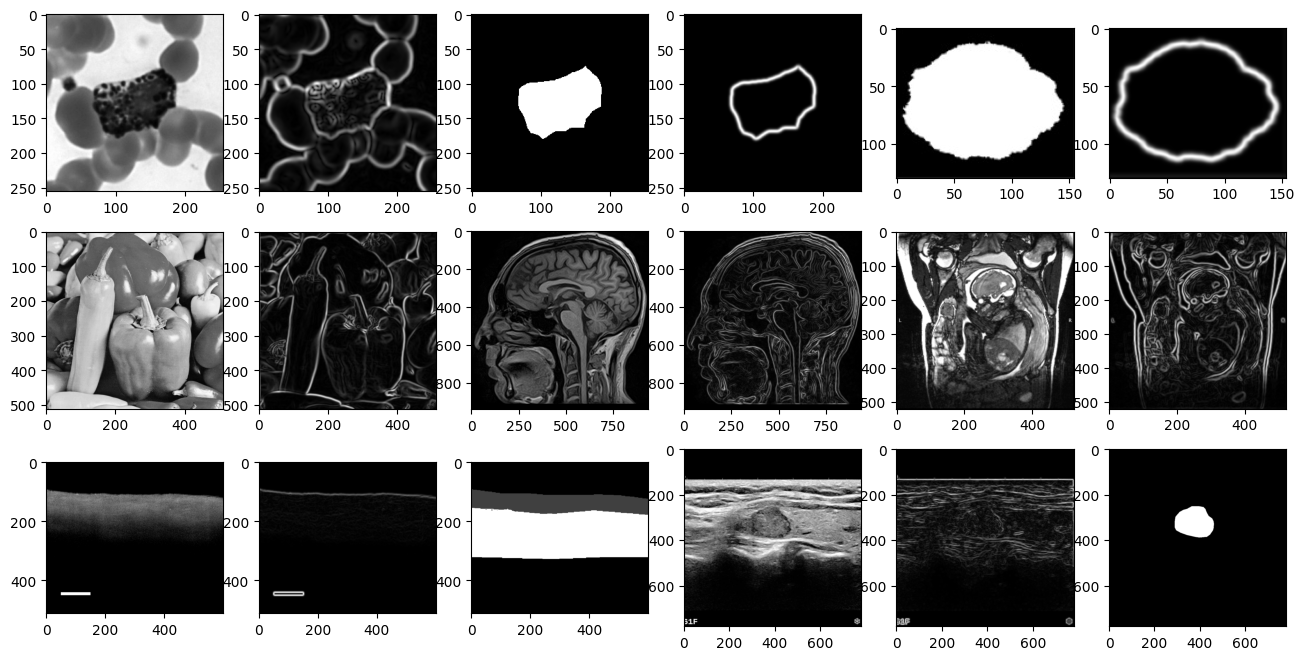

In [4]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)

img_hela    = skimage.io.imread('./images_misc/hela_big_gt.png', as_gray = False)

edge_hela   = edge_map(img_hela, sigma=2)
img_hela = np.squeeze(img_hela)

img_pepper  = skimage.io.imread('./images_misc/peppers_gt.png', as_gray = False)
img_pepper = np.squeeze(img_pepper)

edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper  = img_pepper.astype('float64')




img_MRIb  = skimage.io.imread('./images_misc/MRI_brain_sag.png', as_gray = True)
edge_MRIb = edge_map(img_MRIb, sigma=2)
img_MRIf  = skimage.io.imread('./images_misc/MRI_fetus.png', as_gray = True)
edge_MRIf = edge_map(img_MRIf, sigma=2)


img_cell  = skimage.io.imread('./images_blood_cells/000016.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)

img_mask = skimage.io.imread('./masks_blood_cells/000016.png', as_gray = True)
edge_mask = edge_map(img_mask, sigma=2)
img_mask2 = skimage.io.imread('./images_misc/binary_shape_2024.png', as_gray = True)
edge_mask2 = edge_map(img_mask2, sigma=2)
# skimage.io.imshow(img_mask)

img_OCT  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)


img_nodule = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)


fig, axes = plt.subplots(3,6, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(img_mask, cmap=plt.cm.gray);
ax[3].imshow(edge_mask, cmap=plt.cm.gray);
ax[4].imshow(img_mask2, cmap=plt.cm.gray);
ax[5].imshow(edge_mask2, cmap=plt.cm.gray);

ax[6].imshow(img_pepper, cmap=plt.cm.gray);
ax[7].imshow(edge_pepper, cmap=plt.cm.gray);
ax[8].imshow(img_MRIb, cmap=plt.cm.gray);
ax[9].imshow(edge_MRIb, cmap=plt.cm.gray);
ax[10].imshow(img_MRIf, cmap=plt.cm.gray);
ax[11].imshow(edge_MRIf, cmap=plt.cm.gray);
ax[12].imshow(img_OCT, cmap=plt.cm.gray);
ax[13].imshow(edge_OCT, cmap=plt.cm.gray);
ax[14].imshow(labels_OCT, cmap=plt.cm.gray);
ax[15].imshow(img_nodule, cmap=plt.cm.gray);
ax[16].imshow(edge_nodule, cmap=plt.cm.gray);
ax[17].imshow(labels_nodule, cmap=plt.cm.gray);

# Image properties: 
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
255.0


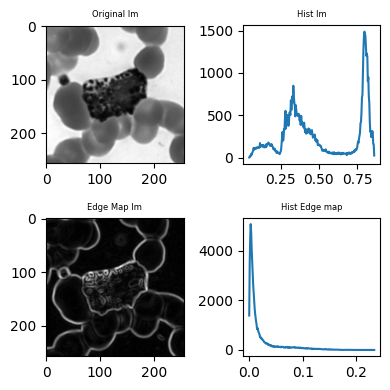

In [5]:

img_test  = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_pepper))


## Show Hist
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map. 

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use. 
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero. 

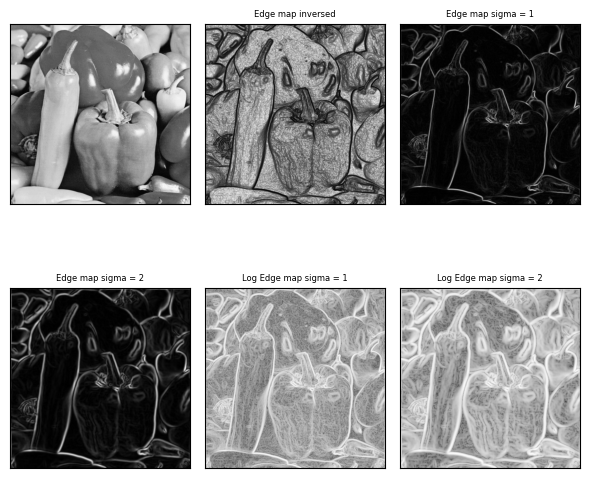

In [6]:

img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test1_l       = np.log2(edge_test1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=1.0) 


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[1].set_title("Edge map inversed", fontsize=6);
ax[2].imshow(edge_test1, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 1", fontsize=6);
ax[3].imshow(edge_test2, cmap=plt.cm.gray);
ax[3].set_title("Edge map sigma = 2", fontsize=6);
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray);
ax[4].set_title("Log Edge map sigma = 1", fontsize=6);
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[5].set_title("Log Edge map sigma = 2", fontsize=6);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation. 
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

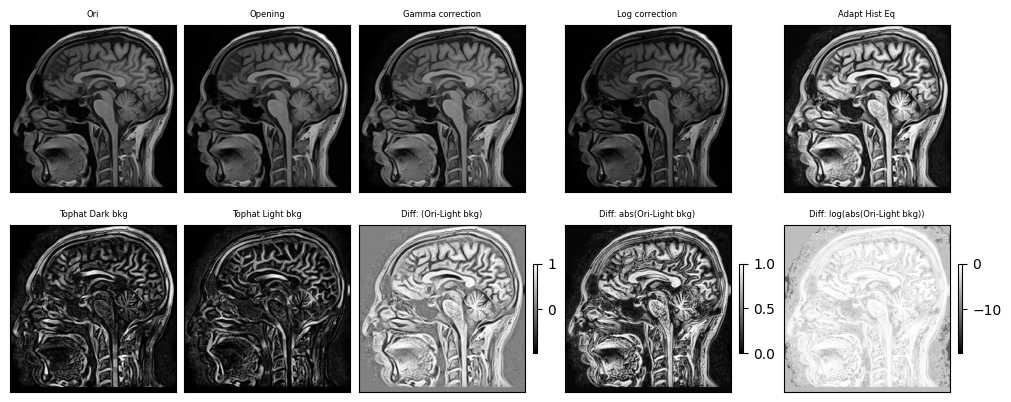

In [7]:
img_ori_to_test = img_MRIb 
img_to_test     = img_ori_to_test
epsilon         = 0.000001 #to prevent log on 0 
img_eps         = np.full_like(img_to_test, epsilon)
PRE_ENHANCE     = 1
OPTION_ENHANCE  = 4 # can be 0 (nothing) OR 1,2,3,4 for different enchancement options

# Run all  OPTION_ENHANCE for display here       
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
    elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 15
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=6);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=6);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=6);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=6);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=6);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=6);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2+img_eps)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

for i in range(0,10):
    ax[i].set_xticks([]), ax[i].set_yticks([]);
    
#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1: 
### Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br> 
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark 
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges

 
## TODO:
1. Run the cell for **img_to_seg=img_mask** and **img_to_seg=img_mask2** with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>
    1. Comment on defaults seen on the obtained initial segmentations. <br>
    1. Explain why you think increasing the gamma_val has better helped smooth the final contour.  <br>

2. Test now by using a small initial circle inside the white shape. What is happening and what additional force seen in the class could help fixing this issue?

3. Now run the segmentation on the **img_to_seg=img_star** or **img_to_seg=img_star_noisy**. Try the same parameter values adjustments as before to get a smoother final contour. Comment on the issues observed with the two options.
4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable.

### Answers

1.1) In setups 1 and 3, the final contour doesn't precisely match the shape, showing 'peaks' along its path. However, setup 3, with a higher beta value, presents a smoother contour compared to setup 1. Setup 2, having the highest viscosity, aligns closest to the expected contour.

1.2) High viscosity intuitively slows down contour movement, allowing its internal forces to act gradually. This prevents the peaks observed in setups 1 and 3.

2.) When the circle sits entirely within the white shape, the contour stops at the circle. To fix this, adding a pressure force can push the contour to expand.

3.) Using the first parameter set, the contour isn't very smooth, particularly with 'img_star'. The second set yields a smoother but less accurate contour due to a longer path to reach the image edges, keeping close to the initial circle. The third set creates an irregular contour but smoother than the first.

Segmenting 'img_star_noisy' is challenging; small changes in parameters, especially viscosity, significantly impact the outcome. If viscosity is too high, no segmentation occurs. Fixing $\gamma$ at 0.0012, the most satisfactory results emerge around $\beta$ = 1, but smaller curvatures are poorly segmented regardless of parameter values.

The segmentation works better on images that don't have noise because the algorithm often mistakes the noise for edges. This leads to misinterpretations, affecting the segmentation's accuracy.

4.) For optimal adaptation to the contour, recalculating forces multiple times is crucial. Slowing down point movement to recalculate forces more often, setting 17,000 iterations, achieves this goal.


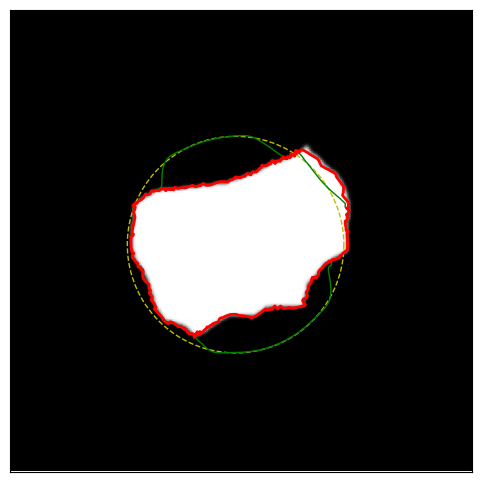

In [8]:
# 1ST image
img_to_seg=img_mask; r0 = 130; c0=125; R0 = 60
#img_to_seg=img_mask2; r0 = 75; c0=65; R0 = 60 

#alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.05; convergence_val = 1e-4;Niter_snake = 800; 
#alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800; 
alpha_val  = 0.01 ; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800; 

# 2ND image
#img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
#img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50
#alpha_val  = 0.005 ; beta_val = 0.1; gamma_val = 0.012; convergence_val = 1e-4; Niter_snake = 17000; 


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image 
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour 
snake10 = active_contour(img_to_seg,
                       init, max_num_iter=10, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(img_to_seg, cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);

plt.show();

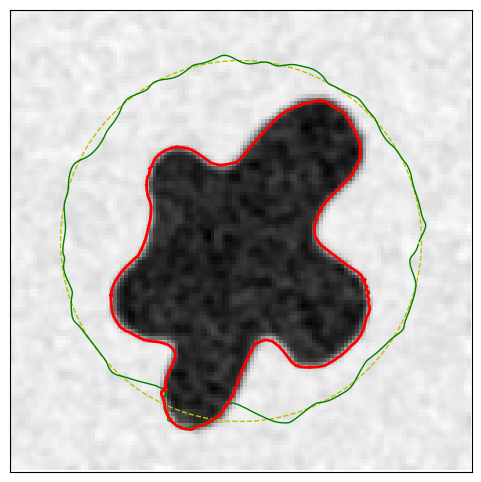

In [9]:
# 1ST image
#img_to_seg=img_mask; r0 = 130; c0=125; R0 = 60
#img_to_seg=img_mask2; r0 = 75; c0=65; R0 = 60 

#alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.05; convergence_val = 1e-4;Niter_snake = 800; 
#alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800; 
#alpha_val  = 0.01 ; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800; 

# 2ND image
#img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50
alpha_val  = 0.005 ; beta_val = 0.1; gamma_val = 0.012; convergence_val = 1e-4; Niter_snake = 17000; 


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image 
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour 
snake10 = active_contour(img_to_seg,
                       init, max_num_iter=10, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(img_to_seg, cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);

plt.show();

# Seg #2: 
### Snake on a real image 

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO
1. **Segment left cell**: 
    1. Run with the proposed initialisation and see that the active contour can be initialised inside the object. Give some intuition on why. 
2. **Segment right cell**:
    1. Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why.
    2. Change the parameter **Niter_smooth** while keeping snake parameters constant and give an intuition on why the final contour evolves as seen. 
    1. Change the initial contour parameters to obtain a perfect segmentation. 
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters [r0 ; c0; R0 ] that works on this image.

### Answers

1) The process succeeds because within the object, pixel intensity isn't consistently uniform but also doesn't fluctuate significantly. Thus, the algorithm detects smaller gradients within the object compared to the edges, aiding in shape detection.

2.1) However, this method fails when the object's interior displays substantial variations in pixel intensity. These variations might mistakenly be identified as edges by the algorithm, leading to inaccuracies in the detection process.

2.2) Increasing this parameter aids in contour detection by enhancing cell homogeneity. Yet, excessive blur can render the cell indiscernible, resulting in an unclear final contour.

2.3) Achieving a flawless cell segmentation is possible with specific parameters like Niter_smooth=2 and R0=62.

3.) To automatically initialize:
### Step 1: Segmentation Preparation

#### Thresholding
- **Objective:** Identify the darkest regions in the image.
- **Algorithm:**
  - Set a predefined threshold value to distinguish between dark and non-dark pixels.
  - Assign pixel values above the threshold to 0 (black) and the rest to 1 (white) to create a binary mask.
- **Purpose:** Create a mask highlighting areas likely to belong to the darkest cell.

#### Morphological Operations (Closing)
- **Objective:** Refine the segmentation for better-defined regions.
- **Algorithm:**
  - Apply a morphological closing operation using a predefined structuring element (e.g., a square-shaped kernel).
  - Closing fills small gaps and smoothens the edges in the binary mask.
- **Purpose:** Enhance the segmentation by joining nearby dark regions and filling small gaps.

### Step 2: Identifying the Darkest Cell

#### Connected Components Labeling
- **Objective:** Identify distinct connected regions in the binary mask.
- **Algorithm:** Label connected components in the binary mask using an algorithm that assigns unique labels to each connected region.

#### Selection of the Darkest Cell
- **Objective:** Determine the region presumed to represent the darkest cell.
- **Algorithm:**
  - Calculate properties (such as area) for each labeled region using methods like regionprops.
  - Identify the region with the largest area, assuming it represents the darkest cell.
  - Retrieve properties of this largest region (such as centroid and bounding box parameters).

### Summary
- **Objective:** Automatically initialize the initial active contour parameters targeting the darkest cell.
- **Approach:**
  - Thresholding and morphological operations prepare a binary mask to highlight potentially dark areas.
  - Labeling and analysis of connected components help identify the largest region, assumed to be the darkest cell.
  - Centroid and bounding box parameters of this region serve as initial estimates for the active contour parameters [r0, c0, R0].


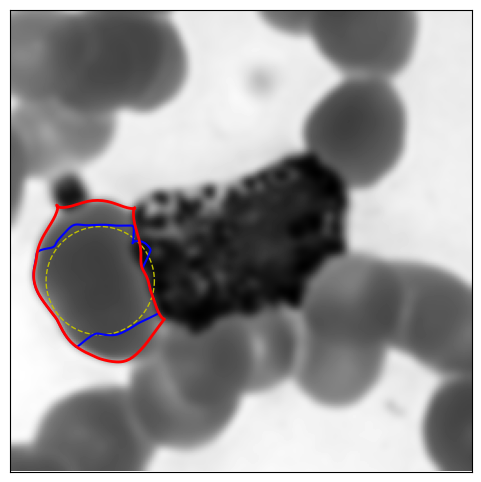

In [10]:

# Input image and parameter values
img_to_seg   =  img_cell; 

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
#r0 = 130; c0=120; R0 = 62
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
#convergence_val = 1e-4; Niter_snake = 800;



# Pre smooth the image
Niter_smooth = 2
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Run active contour 
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

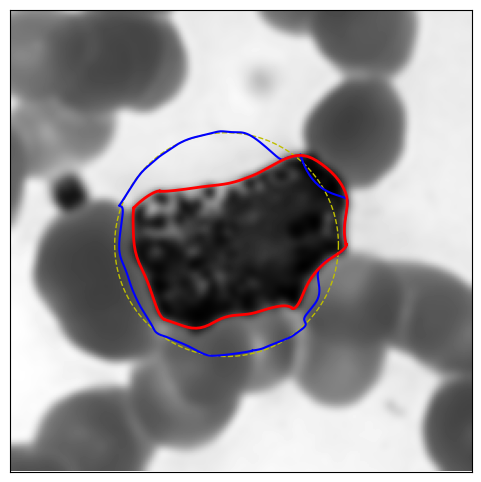

In [11]:

# Input image and parameter values
img_to_seg   =  img_cell; 

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
#convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 62
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 800;



# Pre smooth the image
Niter_smooth = 2
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Run active contour 
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

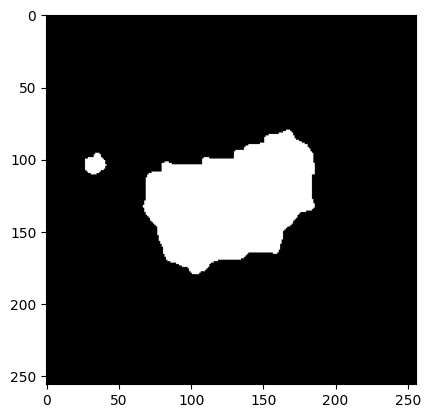

In [12]:
import copy
import cv2
from scipy.ndimage import median_filter

img_init_test   =  copy.copy(img_cell); 
img_to_seg   =  img_cell; 

threshold = 60
img_init_test[img_init_test > threshold/255] = 0
img_init_test[img_init_test != 0] = 1

kernel = np.ones((15, 15), np.uint8)

img_init_test = cv2.morphologyEx(img_init_test, cv2.MORPH_CLOSE, kernel)

plt.imshow(img_init_test, cmap='gray')
plt.show();


([], [])

(0.0, 256.0, 256.0, 0.0)

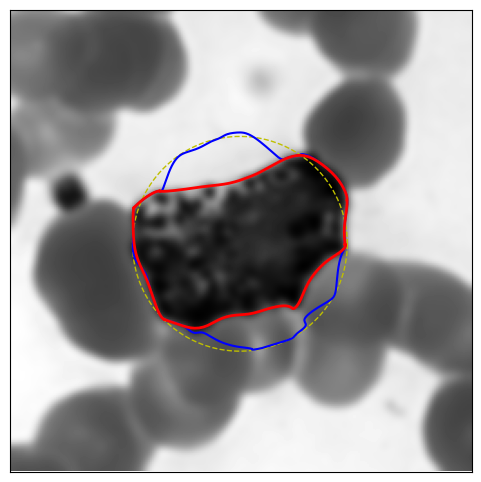

In [13]:
from scipy import ndimage as ndi
from skimage.measure import regionprops

alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 800;

# Label the connected regions in the segmented mask
labeled_cells, num_cells = ndi.label(img_init_test)

# Get properties of each labeled region (cell)
cell_props = regionprops(labeled_cells)

# Find the largest region (assuming it's the darkest cell)
largest_cell = max(cell_props, key=lambda x: x.area)

# Get the centroid and bounding box parameters
r0, c0 = largest_cell.centroid
R0 = max(largest_cell.bbox[2] - largest_cell.bbox[0], largest_cell.bbox[3] - largest_cell.bbox[1]) / 2

# Run active contour
init = define_initial_circle(R0, r0, c0)
# Pre smooth the image
Niter_smooth = 2
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Run active contour 
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

plt.show()


# Seg # 3

### A tool to visualise the deformations of the snake


## TO DO:
1. **Segment left cell**:
    1. Provide your comments on the deformation pattern of the snake. 
    1. Why iteration time steps get slower over iterations when initialising from the inside? 
1. **Segment right cell**:
     1. Use your optimal parameters from previous cell and comment on the deformation patterns.

### Answers

1.1. In the initial stages of the video, the algorithm grapples with discerning clear contours, resulting in fragmented lines and a slower pace. Towards the end, the contours progressively smooth out and snugly enclose the cell, fitting its shape accurately.

1.2. Due to the cell's high uniformity, the algorithm advances cautiously with minute steps, struggling to confidently differentiate whether a contour is detected or not. The inherent fuzziness of the contour also contributes to the slowdown. Also if the curve becomes lengthier as we add more points, it suggests there could be varying quantities of points within this snake method. Therefore, a longer snake implies increased computational requirements.

2.1. The algorithm experiences prolonged runtime owing to the intricacy of the cell's texture. It becomes challenging to distinguish between the background and the brighter sections of the cell, necessitating an extensive examination of a larger image area to attain a satisfactory result.

start
1  

11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


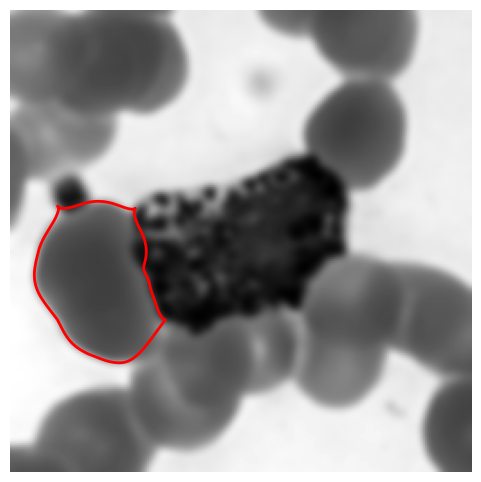

In [14]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
#r0 = 130; c0=120; R0 = 62 # initialise inside
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 2
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
init = define_initial_circle(R0,r0,c0)
 

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

start
1  11  

21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  stop


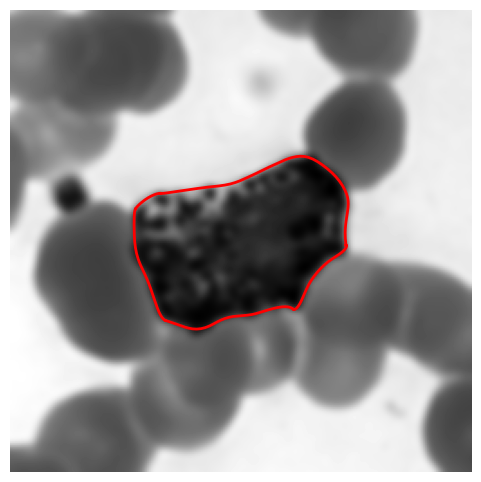

In [15]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 62 # initialise inside
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 2
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
init = define_initial_circle(R0,r0,c0)
 

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO: 

1. Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: img_star, img_star_noisy and an image of your choice. Comment on robustness and speed differences. 
1. When using GVF_map, test the effect of decreasing by a factor of 10 alpha,beta or gamma and interpret the effect.

### Answers
1) In all scenarios, the contour derived using GVF (Gradient Vector Flow) demonstrates smoother curves without the slight oscillations visible in edge_map.

For 'im_star,' GVF swiftly generates a flawless contour within 200 iterations, while edge_map struggles to capture the complete star branch shape. Similarly, 'im_star_noisy' showcases GVF's faster advancement, reaching all star branches compared to edge_map, which lags behind in segmentation progress. This highlights GVF's quicker initialization compared to edge_map.

Conversely, when segmenting the cell, edge_map yields a more satisfactory result than GVF. The cell isn't distinctly discernible with GVF, potentially due to the image's lower contrast. Additionally, the cell's texture complicates segmentation, sometimes treating cell details as contours.

Therefore, GVF proves more adept for high-contrast images, even those with noise. On the contrary, for images with reduced contrast, utilizing edge_map might be more practical.

2) When alpha decreases, the contour tends to lag inside the cell, failing to encompass it entirely, leading to an imprecise segmentation. Conversely, boosting alpha brings the contour closer to the actual cell boundary.

A reduction in beta shifts the contour outward, making it more challenging to align with the cell's true boundary. Conversely, increasing beta aids in getting the contour closer to the accurate shape.

Decreasing gamma, which slows down the process, delivers a more precise result by allowing finer adjustments, but this precision comes at the cost of increased processing time due to the slower progression.

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  stop


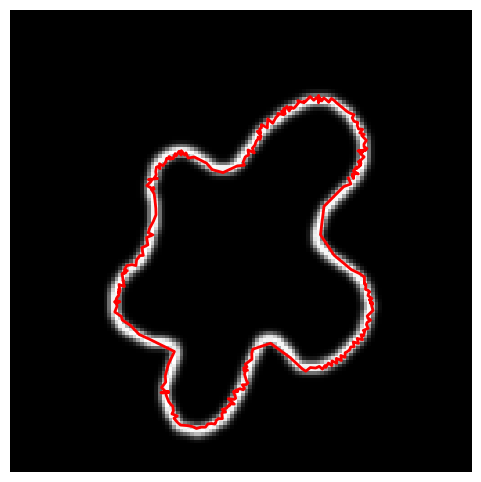

In [16]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

# Example of another image to test. 
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.01; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 400; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

.........................................................

.......................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  stop


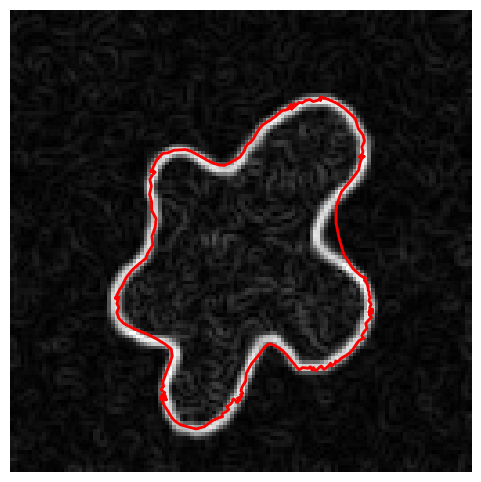

In [17]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_star_noisy
r0 = 64; c0=64; R0 = 45

# Example of another image to test. 
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 400; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

.................

...............................................................................................................................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


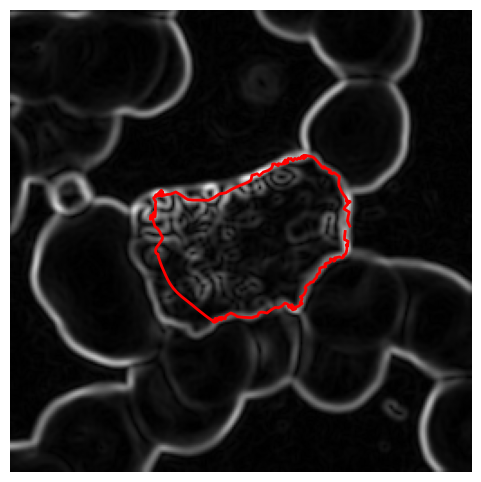

In [18]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_cell
r0 = 119; c0=130; R0 = 52

# Example of another image to test. 
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.001; 
convergence_val = 1e-4; Niter_snake = 200; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map. 
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues. 

## Answers
In this case i implemented the average of the contours


([], [])

[(0.0, 500.0)]

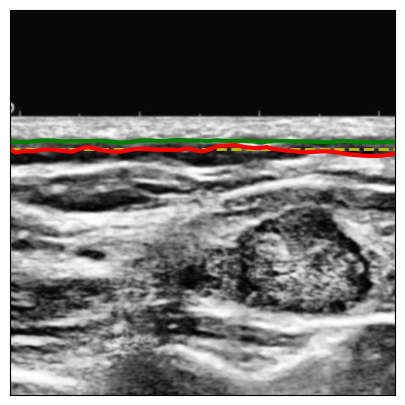

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.filters import gaussian
from skimage.segmentation import active_contour

img_to_seg = img_nodule
r_left = 170; r_right=170; c_left=0; c_right = 780
#r_left = 200; r_right=190; c_left=0; c_right = 780
#r_left = 230; r_right=210; c_left=0; c_right = 780

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=0; w_edge_val=1

# Pre smooth the image
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Loop to vary initial line vertical position
contours = []  # To store final contours
for shift in range(-10, 11, 2):  # Vary initial line position by few pixels
    r_left = 170 + shift
    r_right = 170 + shift
    c_left = 0
    c_right = 780

    # Initialize contour
    Nber_pts_contour = 300
    r = np.linspace(r_left, r_right, Nber_pts_contour)
    c = np.linspace(c_left, c_right, Nber_pts_contour)
    init = np.array([r, c]).T

    # Run active contour with fixed end points
    snake = active_contour(
        img_to_seg,
        init,
        boundary_condition="fixed-fixed",
        max_num_iter=Niter_snake,
        alpha=alpha_val,
        beta=beta_val,
        gamma=gamma_val,
        w_line=w_line_val,
        w_edge=w_edge_val,
    )

    # Store final contour
    contours.append(snake)

# Aggregate final contours (example: averaging)
aggregated_contour = np.mean(contours, axis=0)

# Plotting (example: displaying the last contour)
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(img_to_seg[0:500, :], cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=2)  # Initial contour
ax.plot(contours[-1][:, 1], contours[-1][:, 0], "-r", lw=3)  # Last contour
ax.plot(aggregated_contour[:, 1], aggregated_contour[:, 0], "-g", lw=3)  # Aggregated contour
ax.set_xticks([]), ax.set_yticks([])
ax.set(xlim=(0, 500))
plt.show()

# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO: 
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria. 

## Answers
* I used the gaussian pre filter
* Manually placed the initial contour at the center of the segment
* Provided the result of one segmentation
* To stop the iterations when encountering issues or problems arising from contour deformation, one might establish criteria aimed at identifying irregular or undesirable deformations. These issues may present themselves as irregularities, sudden alterations, or extreme fluctuations in the contour's shape.

One potential approach involves monitoring specific contour characteristics, such as its smoothness or regularity, and terminating the iterations if these characteristics deviate beyond acceptable limits. For instance, detecting abrupt changes in curvature could serve as an indicator of irregular deformations

I provided a code below the image that use the gradient and the threshold to evaluate the deformation

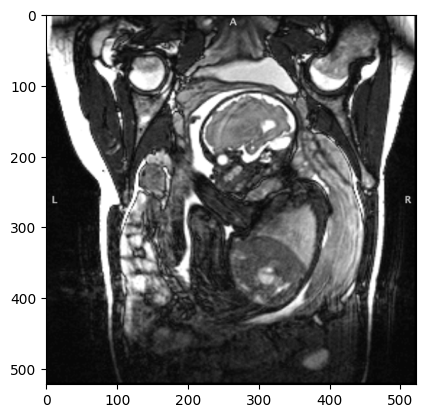

([], [])

(0.0, 522.0, 522.0, 0.0)

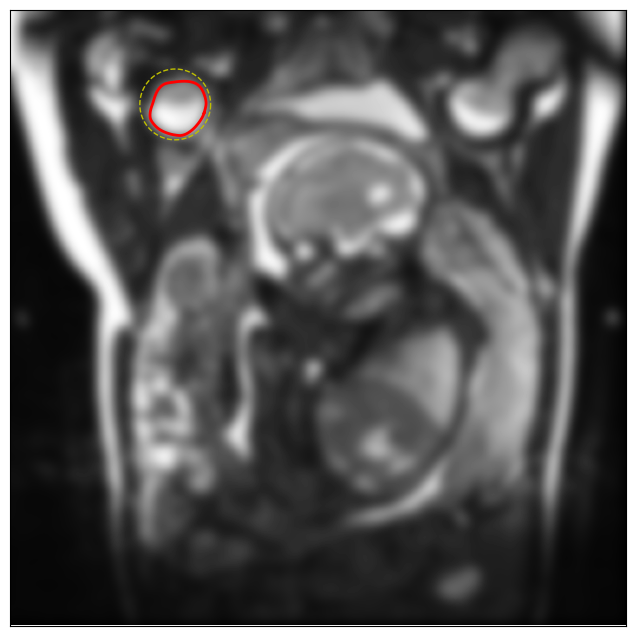

In [20]:
plt.imshow(img_MRIf, cmap='gray')
plt.show()

img_to_seg=img_MRIf

r0=80; c0=140; R0=30; alpha_val = 0.01 ; beta_val = 0.5 ;gamma_val = 0.05; 
convergence_val = 1e-4; Niter_snake = 800;

#1)
Niter_smooth = 5
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


#2)
init = define_initial_circle(R0,r0,c0)

#3)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

In [21]:
def check_curvature_variation(snake):
    """
    Check for abrupt changes in curvature.
    """
    curvature = np.gradient(np.arctan2(np.gradient(snake[:, 0]), np.gradient(snake[:, 1])))
    curvature_variation = np.abs(np.diff(curvature))

    # Consider deformation if any abrupt change in curvature is detected
    return np.any(curvature_variation > 0.1)  # Adjust threshold as needed

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model. 
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms. 
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration. 
1. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.
1. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here. 
1. Make the level set work when initialising with "disk" on img_MRIf 

## Answers
The code of the answers is below
1) This algorithm is based on level sets that are evolved iteratively to minimize an energy, which is defined by weighted values corresponding to the sum of differences intensity from the average value outside the segmented region, the sum of differences from the average value inside the segmented region, and a term which is dependent on the length of the boundary of the segmented region. Then we can see that energy is minimized in each iteration reaching convergence to the zones we want to segment
2) Since the equalization, in general, increases the contrast in the image, we can observe a better segmentation of the image, although some cells are still fused.
3) In this case i implemented the dice similarity which gave a value of around 5,3%
4) The code is provided below


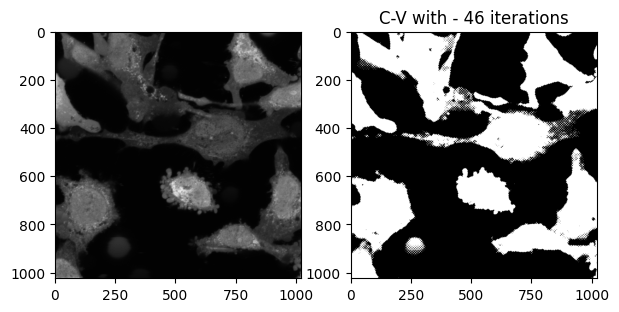

In [22]:

img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

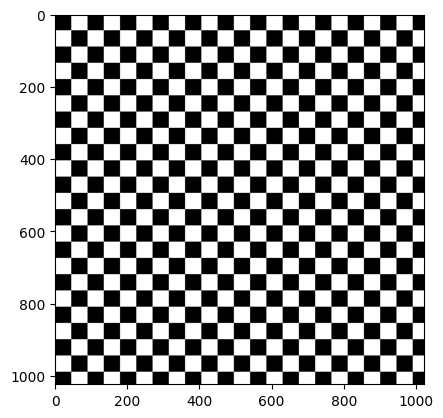

In [23]:
plt.imshow(init_ls, cmap='gray')

Text(0.5, 1.0, '0 iterations')

Text(0.5, 1.0, '1 iterations')

Text(0.5, 1.0, '2 iterations')

Text(0.5, 1.0, '3 iterations')

Text(0.5, 1.0, '4 iterations')

Text(0.5, 1.0, '5 iterations')

Text(0.5, 1.0, '6 iterations')

Text(0.5, 1.0, '7 iterations')

Text(0.5, 1.0, '8 iterations')

Text(0.5, 1.0, '9 iterations')

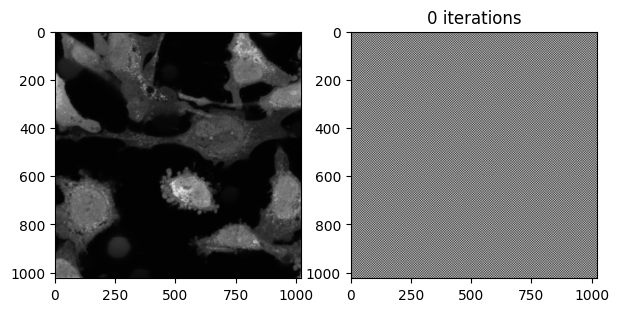

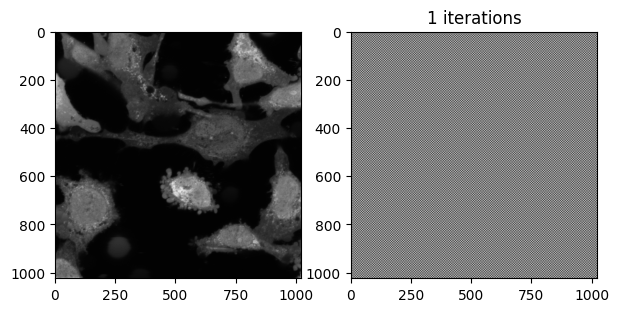

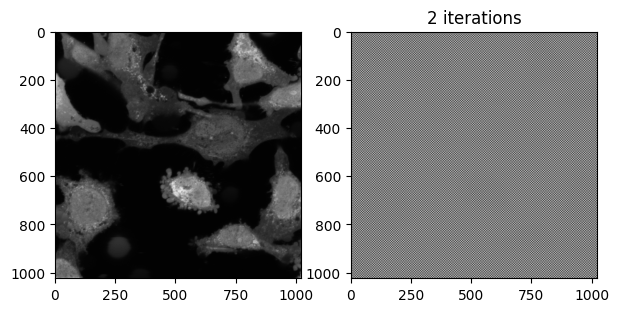

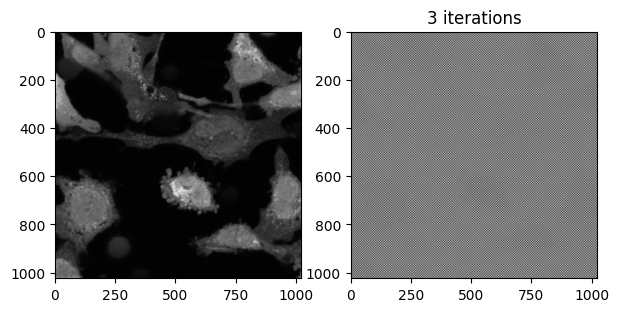

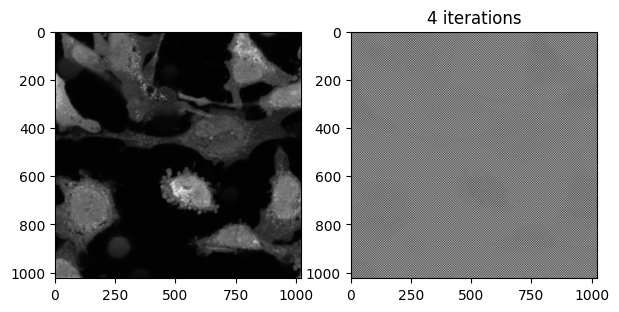

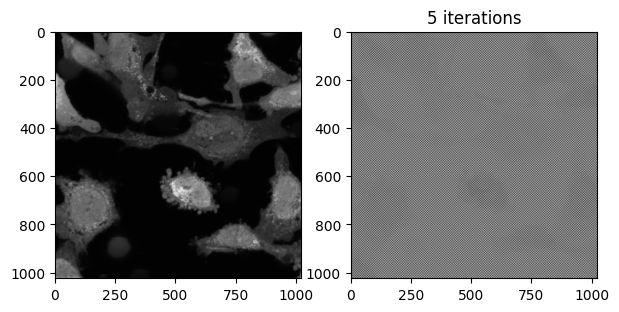

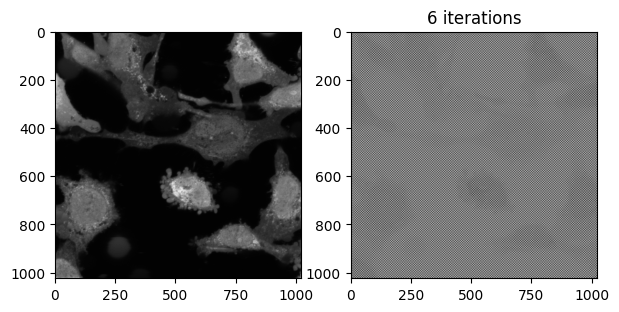

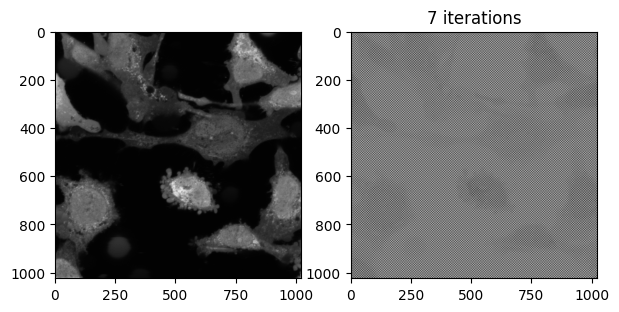

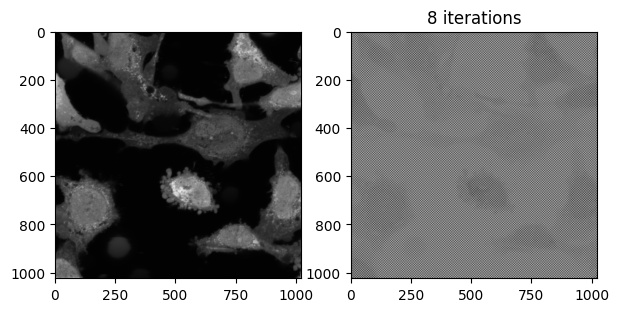

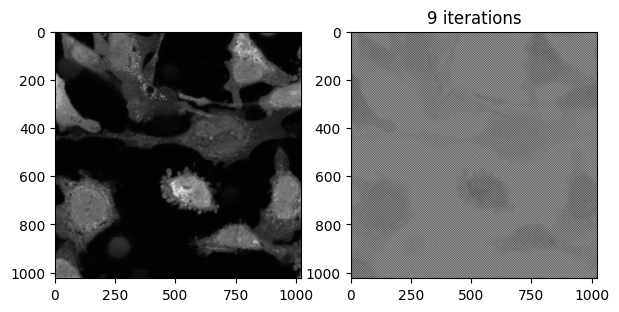

In [40]:
img_to_seg= img_hela

for x in range(0, 10):
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_num_iter=x, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv[1], cmap=plt.cm.gray)
    title = f'{x} iterations'
    ax[1].set_title(title, fontsize=12)

Text(0.5, 1.0, 'Phi x Iteration')

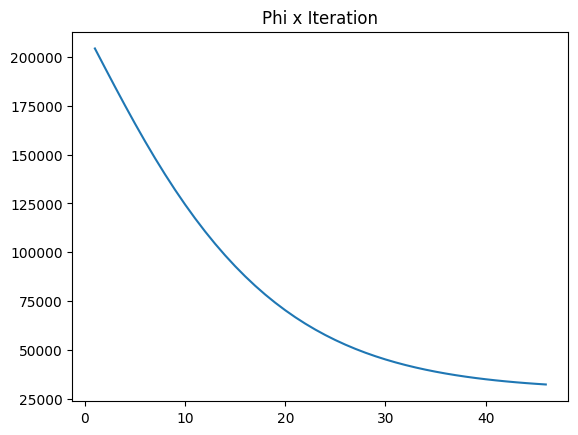

In [24]:
nIter = np.linspace(1, len(cv[2]), len(cv[2]))

plt.plot(nIter, cv[2])
plt.title("Phi x Iteration")

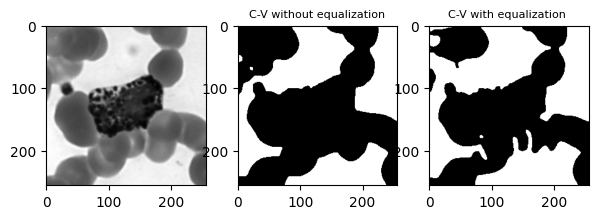

In [25]:
from skimage import exposure

img_to_seg= img_cell

# Preprocessing: Histogram Equalization
img_to_seg_equalized = exposure.equalize_hist(img_to_seg)

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)

    # Run segmentation with histogram equalization preprocessing
    cv_equalized = chan_vese(img_to_seg_equalized, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                         tol=tol_val, dt=dt_val, max_num_iter=Num_iter_cv_ori,
                         init_level_set=Init_method, extended_output=True)


    fig, ax = plt.subplots(1,3,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V without equalization'
    ax[1].set_title(title, fontsize=8)
    ax[2].imshow(1-cv_equalized[0], cmap=plt.cm.gray)
    title = f'C-V with equalization '
    ax[2].set_title(title, fontsize=8)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

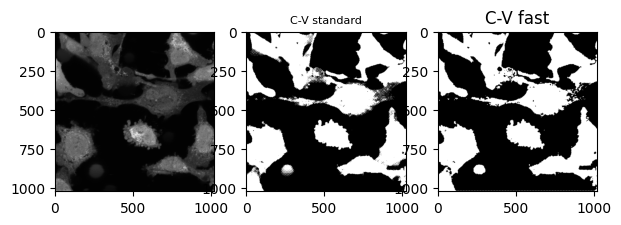

In [26]:
from skimage import exposure

img_to_seg= img_hela


# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
    # STANDARD implementation from original paper 
init_ls = checkerboard_level_set(img_to_seg.shape, 45) 

cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
               tol=tol_val, dt=dt_val, 
               max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
               extended_output=True)
fig, ax = plt.subplots(1,3,figsize=(7, 7))
ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
title = f'C-V standard'
ax[1].set_title(title, fontsize=8)
# FASTER implementation implemented with morphological operators BUT LESS PRECISE
cv2      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast, 
                                  smoothing=smoothing_val, init_level_set="checkerboard")
ax[2].imshow(1-cv2, cmap=plt.cm.gray)
title = f'C-V fast'
ax[2].set_title(title, fontsize=12)


plt.show();

In [27]:
from skimage.measure import label

# Functions for segmentation comparison metrics
def dice_similarity(seg_mask1, seg_mask2):
    intersection = np.logical_and(seg_mask1, seg_mask2)
    return 2.0 * intersection.sum() / (seg_mask1.sum() + seg_mask2.sum())

# Perform label assignment
seg_mask_cv = label(cv[0])
seg_mask_cv2 = label(cv2[0])

# Calculate Dice similarity coefficient
dice_coefficient = dice_similarity(seg_mask_cv, seg_mask_cv2)
print(f"Dice Similarity Coefficient: {dice_coefficient*100}%")

Dice Similarity Coefficient: 1.7781802286728303%


Text(0.5, 1.0, 'C-V with "disk" initialization - 61 iterations')

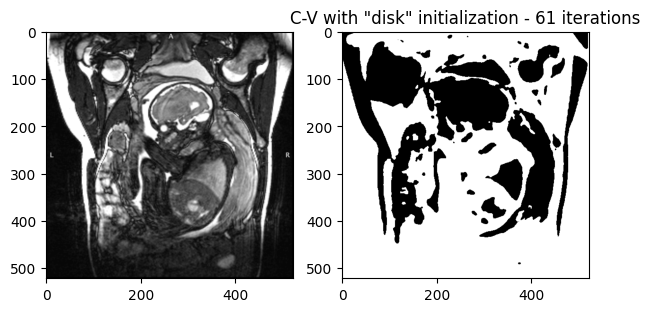

In [28]:
from skimage.segmentation import disk_level_set

# Load img_MRIf or any image you're working with
img_to_seg = img_MRIf

# PARAMETERS
mu_val = 0.5
lambda1_val = 1
lambda2_val = 1
tol_val = 1e-3
dt_val = 0.5
smoothing_val = 3

Num_iter_cv_ori = 61
Init_method = "disk"  # Initialize level set with a "disk"

# Run segmentation with "disk" initialization
init_ls = disk_level_set(img_to_seg.shape, center=(100, 100), radius=50)  # Define the disk parameters
cv_disk = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                    tol=tol_val, dt=dt_val, max_num_iter=Num_iter_cv_ori,
                    init_level_set=init_ls, extended_output=True)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
ax[1].imshow(1 - cv_disk[0], cmap=plt.cm.gray)
title = f'C-V with "disk" initialization - {len(cv_disk[2])} iterations'
ax[1].set_title(title, fontsize=12)
plt.show()


# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?
* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations. 
* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations. 
* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours. 

# Answers
1) In the upper-left corner we can appreciate that there is not a proper segmentation, maybe because there is a region between the real contour and the contour got that has brighter color, so that, the algorithm decides not to include this region. We could then increase the balloon paramater since this parameter helps to guide the contour evolution by providing a supplementary force, influencing the contour's behavior during segmentation, especially in cases where the image gradient information alone might not be sufficient for accurate segmentation (like this case).
2) Code provided below
3) A higher level of smoothing restricts the segmentation to only capturing the larger and smoother structure, which in this case is the brain stem. Conversely, when using a lower smoothing setting, the algorithm is capable of including additional details, allowing it to delineate not just the brain stem but also parts of the spinal cord. This difference arises from how much the smoothing operation simplifies the contour: higher smoothing leads to a more generalized contour, while lower smoothing retains more intricate details in the segmentation result.
4) The main difference in my implementation is that i tried to use 6 disks instead of 1



0.7377611236173724


C:\Users\aleja\AppData\Local\Temp\ipykernel_18536\4220428377.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours");


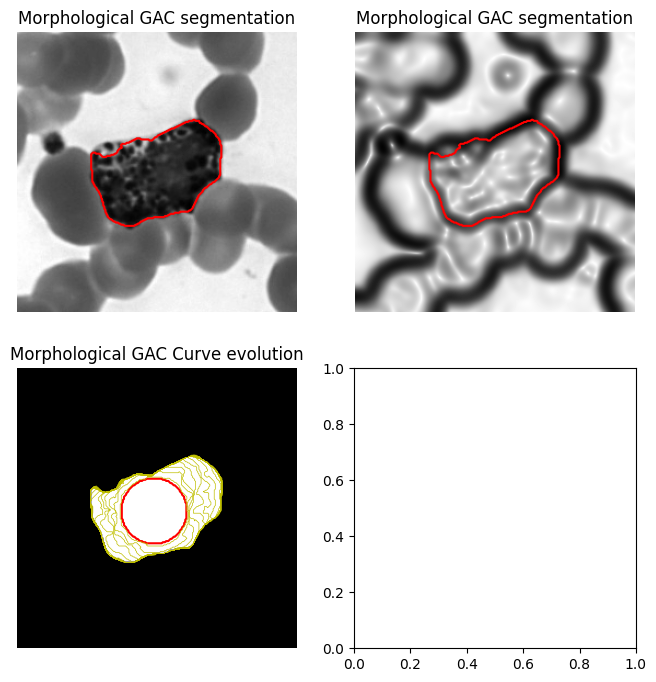

In [29]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();

0.7377611236173724


C:\Users\aleja\AppData\Local\Temp\ipykernel_18536\767157937.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours");


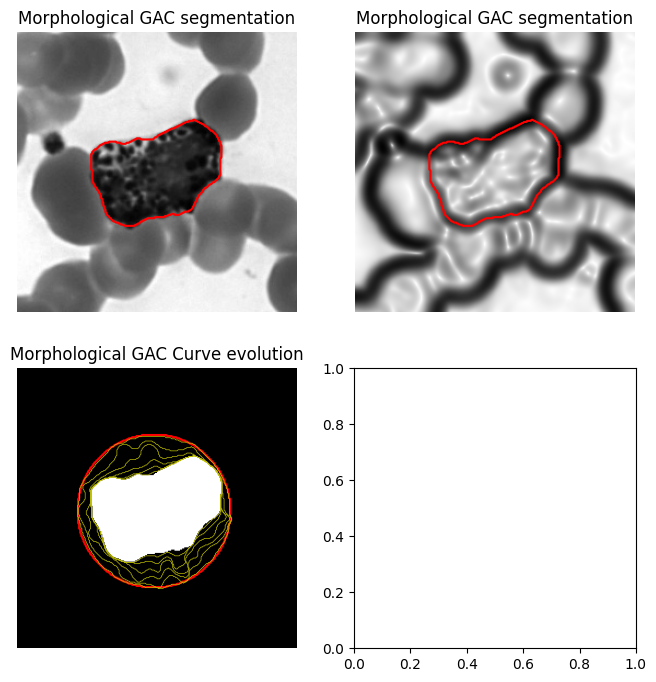

In [30]:
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = -1 ; Smooth_cont_iter = 3 ; 
Niter_snake      = 30

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();

0.785146875520775


C:\Users\aleja\AppData\Local\Temp\ipykernel_18536\2692290216.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours");


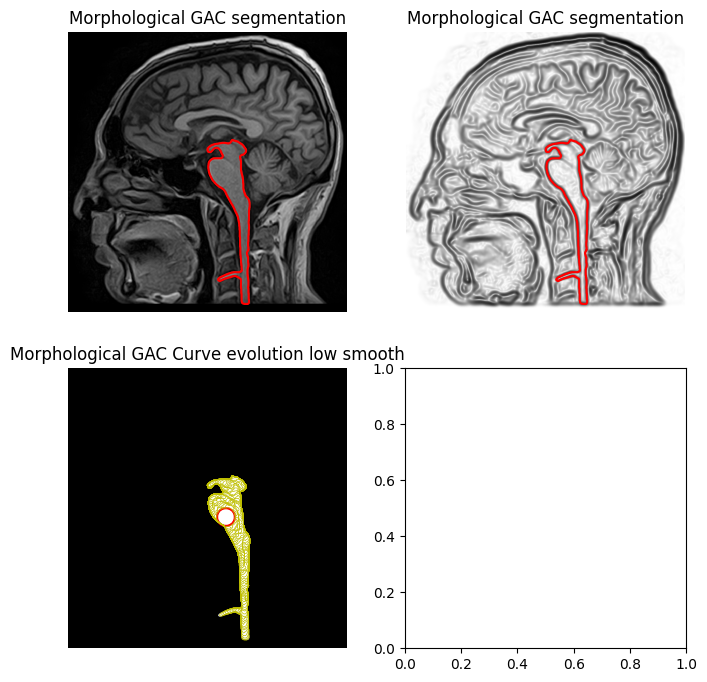

In [31]:
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ;
Niter_snake      = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution low smooth';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.785146875520775


C:\Users\aleja\AppData\Local\Temp\ipykernel_18536\1243790821.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours");


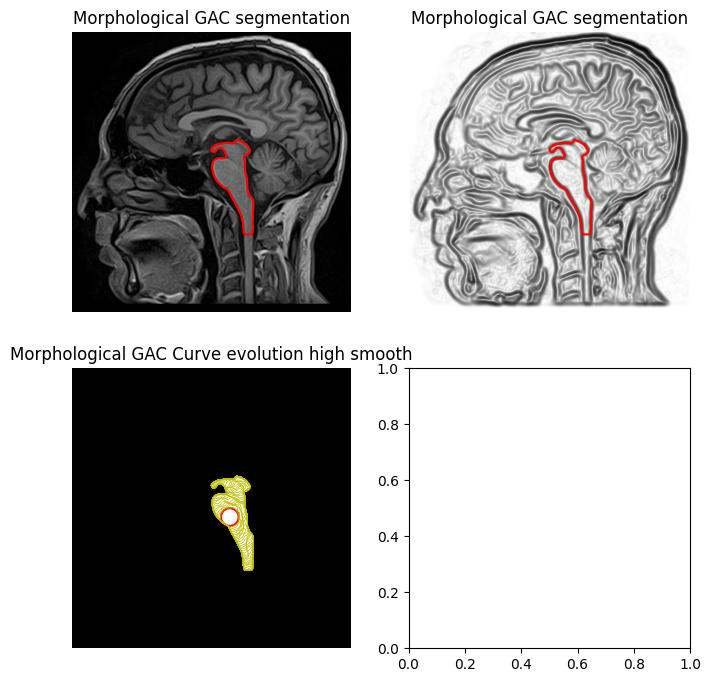

In [32]:
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 5 ;
Niter_snake      = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution high smooth';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.785146875520775


C:\Users\aleja\AppData\Local\Temp\ipykernel_18536\1379691250.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours");


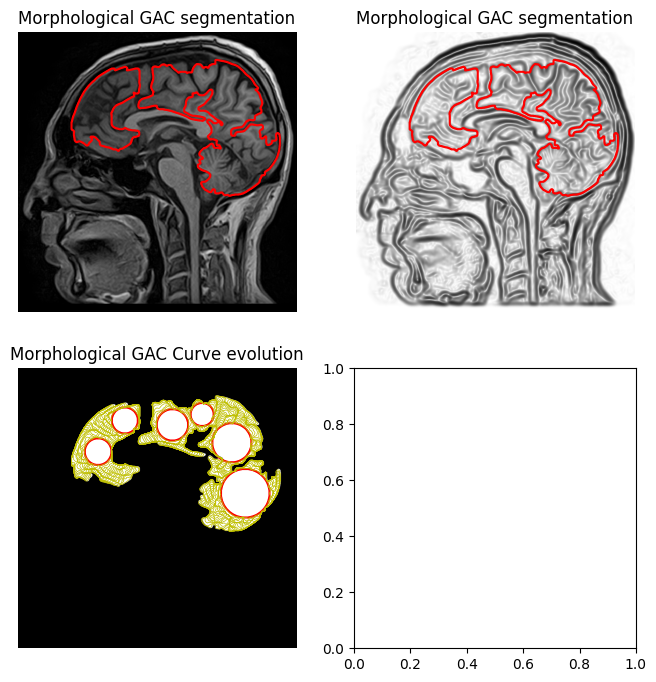

In [33]:
img_to_seg = img_MRIb ; r0 = 220 ; c0 = 700 ; R0 = 100  # for spine and inflate

SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 2 ;
Niter_snake      = 94

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour

disk1 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[280,270], radius=45)
disk2 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[190,520], radius=53)
disk3 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[250,720], radius=66)
disk4 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[420,765], radius=82)

disk5 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[175,360], radius=44)
disk6 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[155,620], radius=39)


init_ls = disk1 + disk2 + disk3 + disk4 + disk5 + disk6

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();